In [1]:
import numpy as np
import pandas as pd
import h5py
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.serif": ["Computer Modern Roman"]})

from meta_feature import dataset_ids_CC18, anchor_list_denser, feature_num_CC18, class_num_CC18, learner_zoo
from utils import fit_model, global_monotonicity_violation, global_convexity_violation, curves_models_fitting

In [ ]:
file_paths = [  Path.cwd() / '../dataset/LCDB11_ER_CC18_noFS_raw.hdf5',
                Path.cwd() / '../dataset/LCDB11_ER_CC18_minmaxFS_raw.hdf5',
                Path.cwd() / '../dataset/LCDB11_ER_CC18_standardFS_raw.hdf5']
dataset_nofs, dataset_minmaxfs, dataset_standardfs = [h5py.File(fp, 'r')['error_rate'][...] for fp in file_paths]

mean_valid_lc_nofs = np.nanmean(dataset_nofs[:,:,:,:,:,1], axis=(2,3))
mean_valid_lc_minmaxfs = np.nanmean(dataset_minmaxfs[:,:,:,:,:,1], axis=(2,3))
mean_valid_lc_standardfs = np.nanmean(dataset_standardfs[:,:,:,:,:,1], axis=(2,3))

In [4]:
mono_matrix_y, mono_matrix_x = global_monotonicity_violation(dataset_nofs, flat_filter = True)
conv_matrix, conv_h_matrix, conv_i_matrix, conv_j_matrix = global_convexity_violation(dataset_nofs, flat_filter = True)

### POW4, MMF4

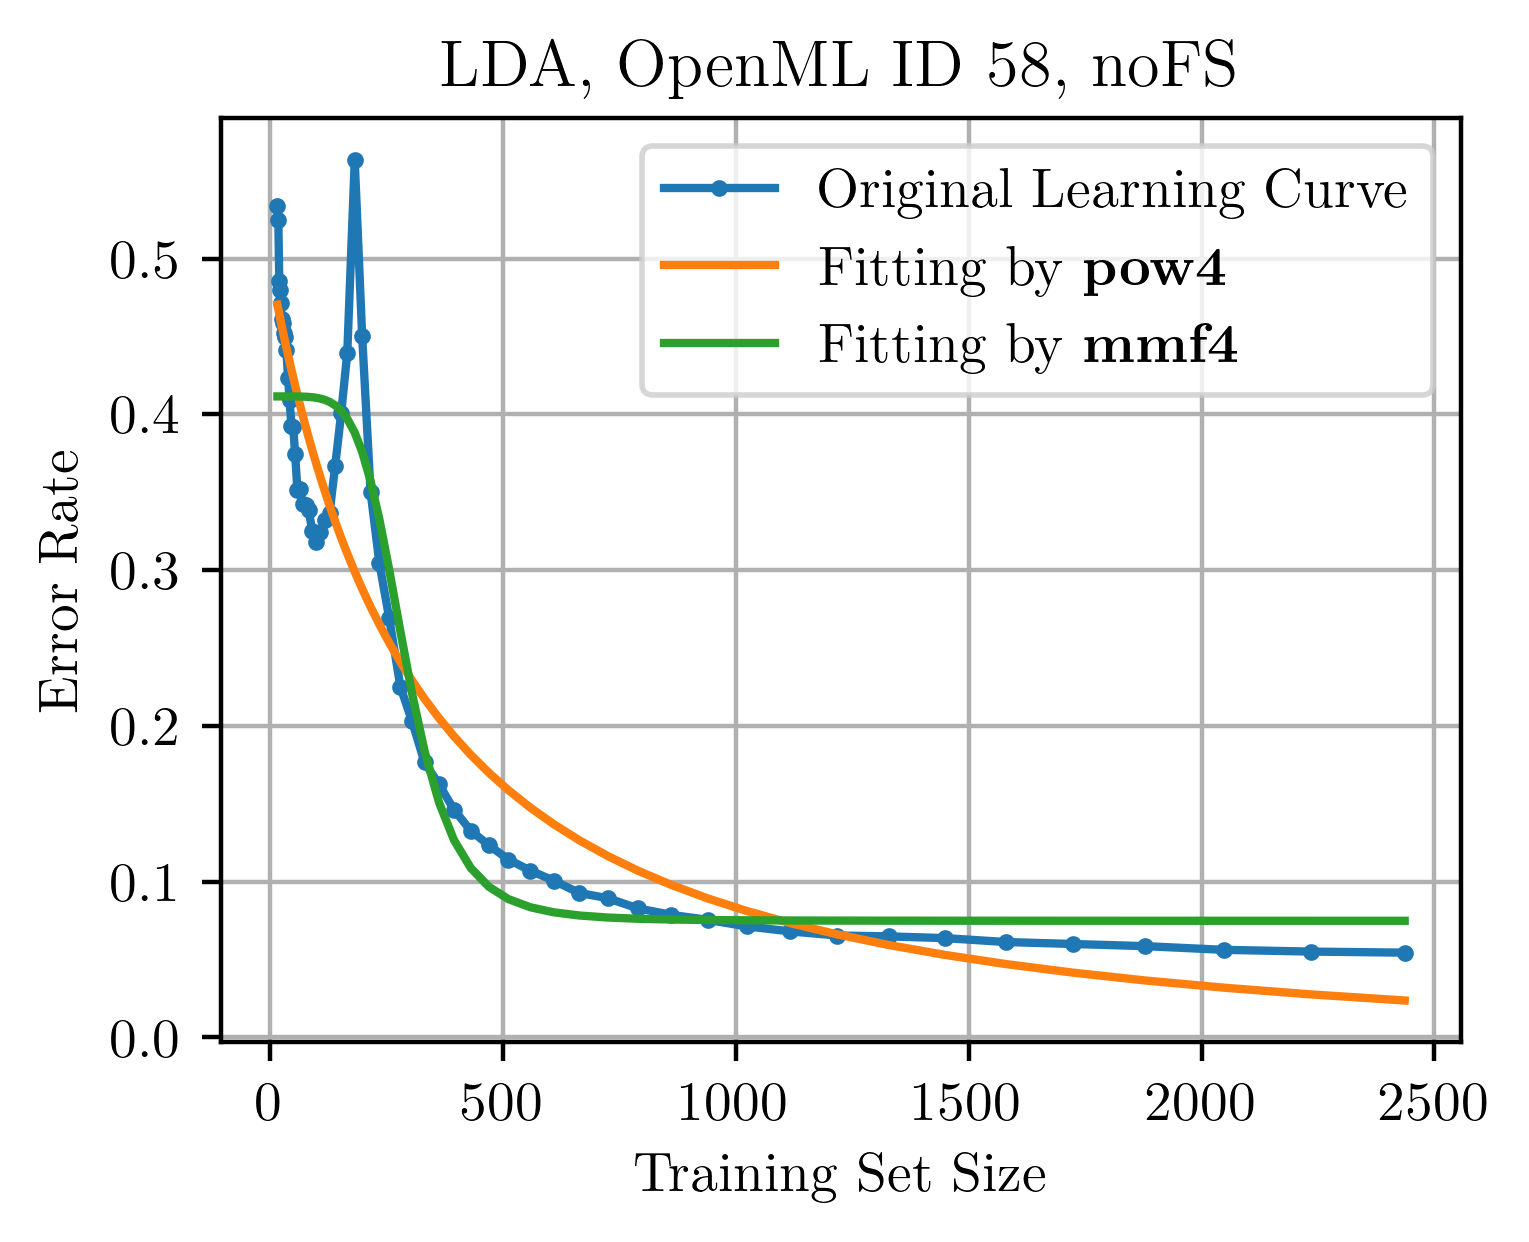

In [9]:
random_learner = random.randint(0, 22) 
random_dataset = random.randint(0, 71)
random_learner, random_dataset = 12, 58
# transition 11, 16 
# peaking 12, 58  # 13, 56 is interesting
# dipping 21, 71

curve_data = mean_valid_lc_nofs[random_dataset, random_learner, :]

fitting_results = curves_models_fitting(
    curve_data, ['pow4'], extrapolate=False, mask_anchor_number=0, eval_anchor_number=0, rep=3
)
result_df = pd.DataFrame(fitting_results)

fitting_results_mmf4 = curves_models_fitting(
    curve_data, ['mmf4'], extrapolate=False, mask_anchor_number=0, eval_anchor_number=0, rep=3
)
result_df_mmf4 = pd.DataFrame(fitting_results_mmf4)

plt.figure(figsize=(4, 3), dpi=400)
curve_length = result_df['scores'][0].shape[0]
plt.plot(anchor_list_denser[:curve_length], result_df['scores'][0], marker='o', markersize=2, label='Original Learning Curve')
plt.plot(anchor_list_denser[:curve_length], result_df['predictions'][0], label=r'Fitting by $\textbf{pow4}$')
plt.plot(anchor_list_denser[:curve_length], result_df_mmf4['predictions'][0], label=r'Fitting by $\textbf{mmf4}$')

plt.title(f'{learner_zoo[random_learner]}, OpenML ID {random_dataset}, noFS')
plt.xlabel('Training Set Size')
plt.ylabel('Error Rate')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
fit_MSE_matrix = np.full((24, 72), np.nan) 
for LEARNER in tqdm(range(23)):   # exclude dummy
    for DATASET in range(72): 
        try:
            fitting_results = curves_models_fitting(mean_valid_lc_nofs[DATASET, LEARNER, :], ['mmf4'], 
                                            extrapolate=False, mask_anchor_number=0, eval_anchor_number=0, 
                                            rep = 3)
            result_df = pd.DataFrame(fitting_results)
            best_mse = result_df["mse"].min()  # mean or min
            fit_MSE_matrix[LEARNER, DATASET] = best_mse
        except: 
            pass

100%|██████████| 23/23 [01:32<00:00,  4.04s/it]


### plot

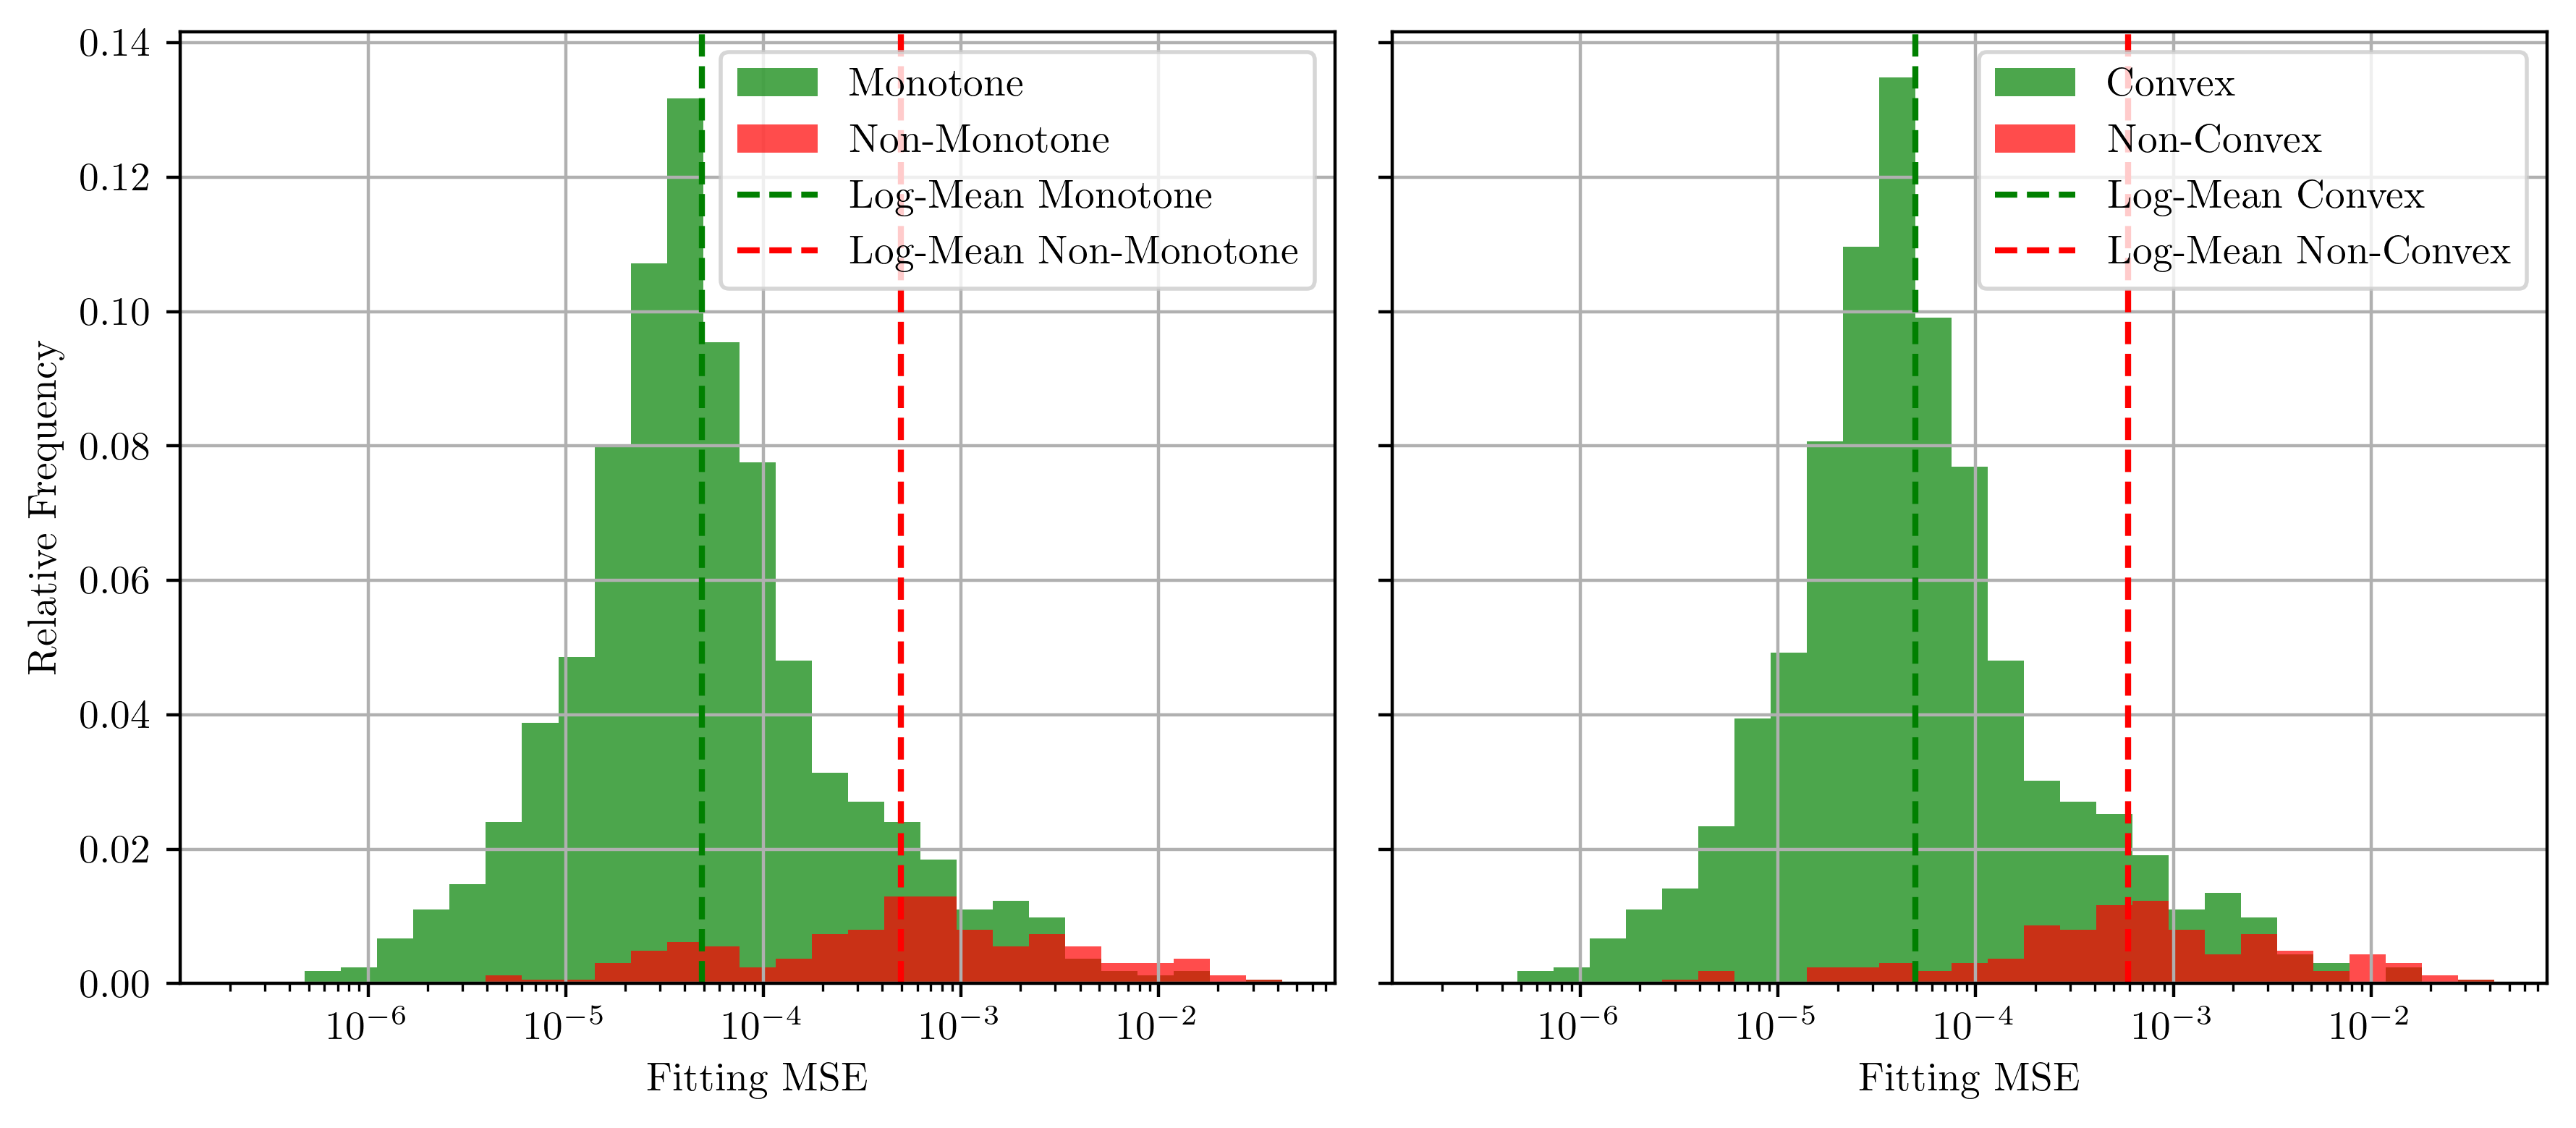

In [9]:
MSE_values_1 = fit_MSE_matrix.flatten()
y_values_1 = mono_matrix_y.flatten()
valid_mask_1 = ~np.isnan(MSE_values_1) & ~np.isnan(y_values_1)
x_valid_well_1 = MSE_values_1[valid_mask_1 & (y_values_1 == 0)]
x_valid_violated_1 = MSE_values_1[valid_mask_1 & (y_values_1 > 0)]

MSE_values_2 = fit_MSE_matrix.flatten()
y_values_2 = conv_matrix.flatten()
valid_mask_2 = ~np.isnan(MSE_values_2) & ~np.isnan(y_values_2)
x_valid_well_2 = MSE_values_2[valid_mask_2 & (y_values_2 == 0)]
x_valid_violated_2 = MSE_values_2[valid_mask_2 & (y_values_2 > 0)]

MSE_values_3 = fit_MSE_matrix.flatten()
mono_violation_error = mono_matrix_y.flatten()
conv_violation_error = conv_matrix.flatten()
valid_mask_3 = ~np.isnan(MSE_values_3) & ~np.isnan(mono_violation_error) & ~np.isnan(conv_violation_error)
mask_well_3 = valid_mask_3 & (mono_violation_error == 0) & (conv_violation_error == 0)
mask_viola_3 = valid_mask_3 & ((mono_violation_error > 0) | (conv_violation_error > 0))
x_valid_well_3 = MSE_values_3[mask_well_3]
x_valid_violated_3 = MSE_values_3[mask_viola_3]

# Common logarithmic bins for all plots
overall_min_bin = min(np.min(x_valid_well_1), np.min(x_valid_violated_1),
                      np.min(x_valid_well_2), np.min(x_valid_violated_2),
                      np.min(x_valid_well_3), np.min(x_valid_violated_3))
overall_max_bin = max(np.max(x_valid_well_1), np.max(x_valid_violated_1),
                      np.max(x_valid_well_2), np.max(x_valid_violated_2),
                      np.max(x_valid_well_3), np.max(x_valid_violated_3))
bins = np.logspace(np.log10(overall_min_bin), np.log10(overall_max_bin), 30)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(9, 4), dpi=400, sharey=True)

# Plot 1
weights_well_1 = np.ones_like(x_valid_well_1) / valid_mask_1.sum()
weights_violated_1 = np.ones_like(x_valid_violated_1) / valid_mask_1.sum()
log_mean_well_1 = np.exp(np.mean(np.log(x_valid_well_1)))
log_mean_violated_1 = np.exp(np.mean(np.log(x_valid_violated_1)))
axes[0].hist(x_valid_well_1, bins=bins, weights=weights_well_1, color='green', alpha=0.7, label="Monotone")
axes[0].hist(x_valid_violated_1, bins=bins, weights=weights_violated_1, color='red', alpha=0.7, label="Non-Monotone")
axes[0].axvline(log_mean_well_1, color='green', linestyle='--', label="Log-Mean Monotone")
axes[0].axvline(log_mean_violated_1, color='red', linestyle='--', label="Log-Mean Non-Monotone")
axes[0].set_xscale("log")
# axes[0].set_xlim(1e-8, 1e-1)
axes[0].set_xlabel("Fitting MSE")
axes[0].set_ylabel("Relative Frequency")
axes[0].legend()
axes[0].grid()

# Plot 2
weights_well_2 = np.ones_like(x_valid_well_2) / valid_mask_2.sum()
weights_violated_2 = np.ones_like(x_valid_violated_2) / valid_mask_2.sum()
log_mean_well_2 = np.exp(np.mean(np.log(x_valid_well_2)))
log_mean_violated_2 = np.exp(np.mean(np.log(x_valid_violated_2)))
axes[1].hist(x_valid_well_2, bins=bins, weights=weights_well_2, color='green', alpha=0.7, label="Convex")
axes[1].hist(x_valid_violated_2, bins=bins, weights=weights_violated_2, color='red', alpha=0.7, label="Non-Convex")
axes[1].axvline(log_mean_well_2, color='green', linestyle='--', label="Log-Mean Convex")
axes[1].axvline(log_mean_violated_2, color='red', linestyle='--', label="Log-Mean Non-Convex")
axes[1].set_xscale("log")
# axes[1].set_xlim(1e-8, 1e-1)
axes[1].set_xlabel("Fitting MSE")
axes[1].legend()
axes[1].grid()

# Plot 3
# weights_well_3 = np.ones_like(x_valid_well_3) / valid_mask_3.sum()
# weights_violated_3 = np.ones_like(x_valid_violated_3) / valid_mask_3.sum()
# log_mean_well_3 = np.exp(np.mean(np.log(x_valid_well_3)))
# log_mean_violated_3 = np.exp(np.mean(np.log(x_valid_violated_3)))
# axes[2].hist(x_valid_well_3, bins=bins, weights=weights_well_3, color='green', alpha=0.7, label="Well-behaved")
# axes[2].hist(x_valid_violated_3, bins=bins, weights=weights_violated_3, color='red', alpha=0.7, label="Ill-behaved")
# axes[2].axvline(log_mean_well_3, color='green', linestyle='--', label="Log-Mean Well-behaved")
# axes[2].axvline(log_mean_violated_3, color='red', linestyle='--', label="Log-Mean Ill-behaved")
# axes[2].set_xscale("log")
# # axes[2].set_xlim(1e-8, 1e-1)
# axes[2].set_xlabel("Fitting MSE")
# axes[2].legend()
# axes[2].grid()

plt.tight_layout()
plt.show()


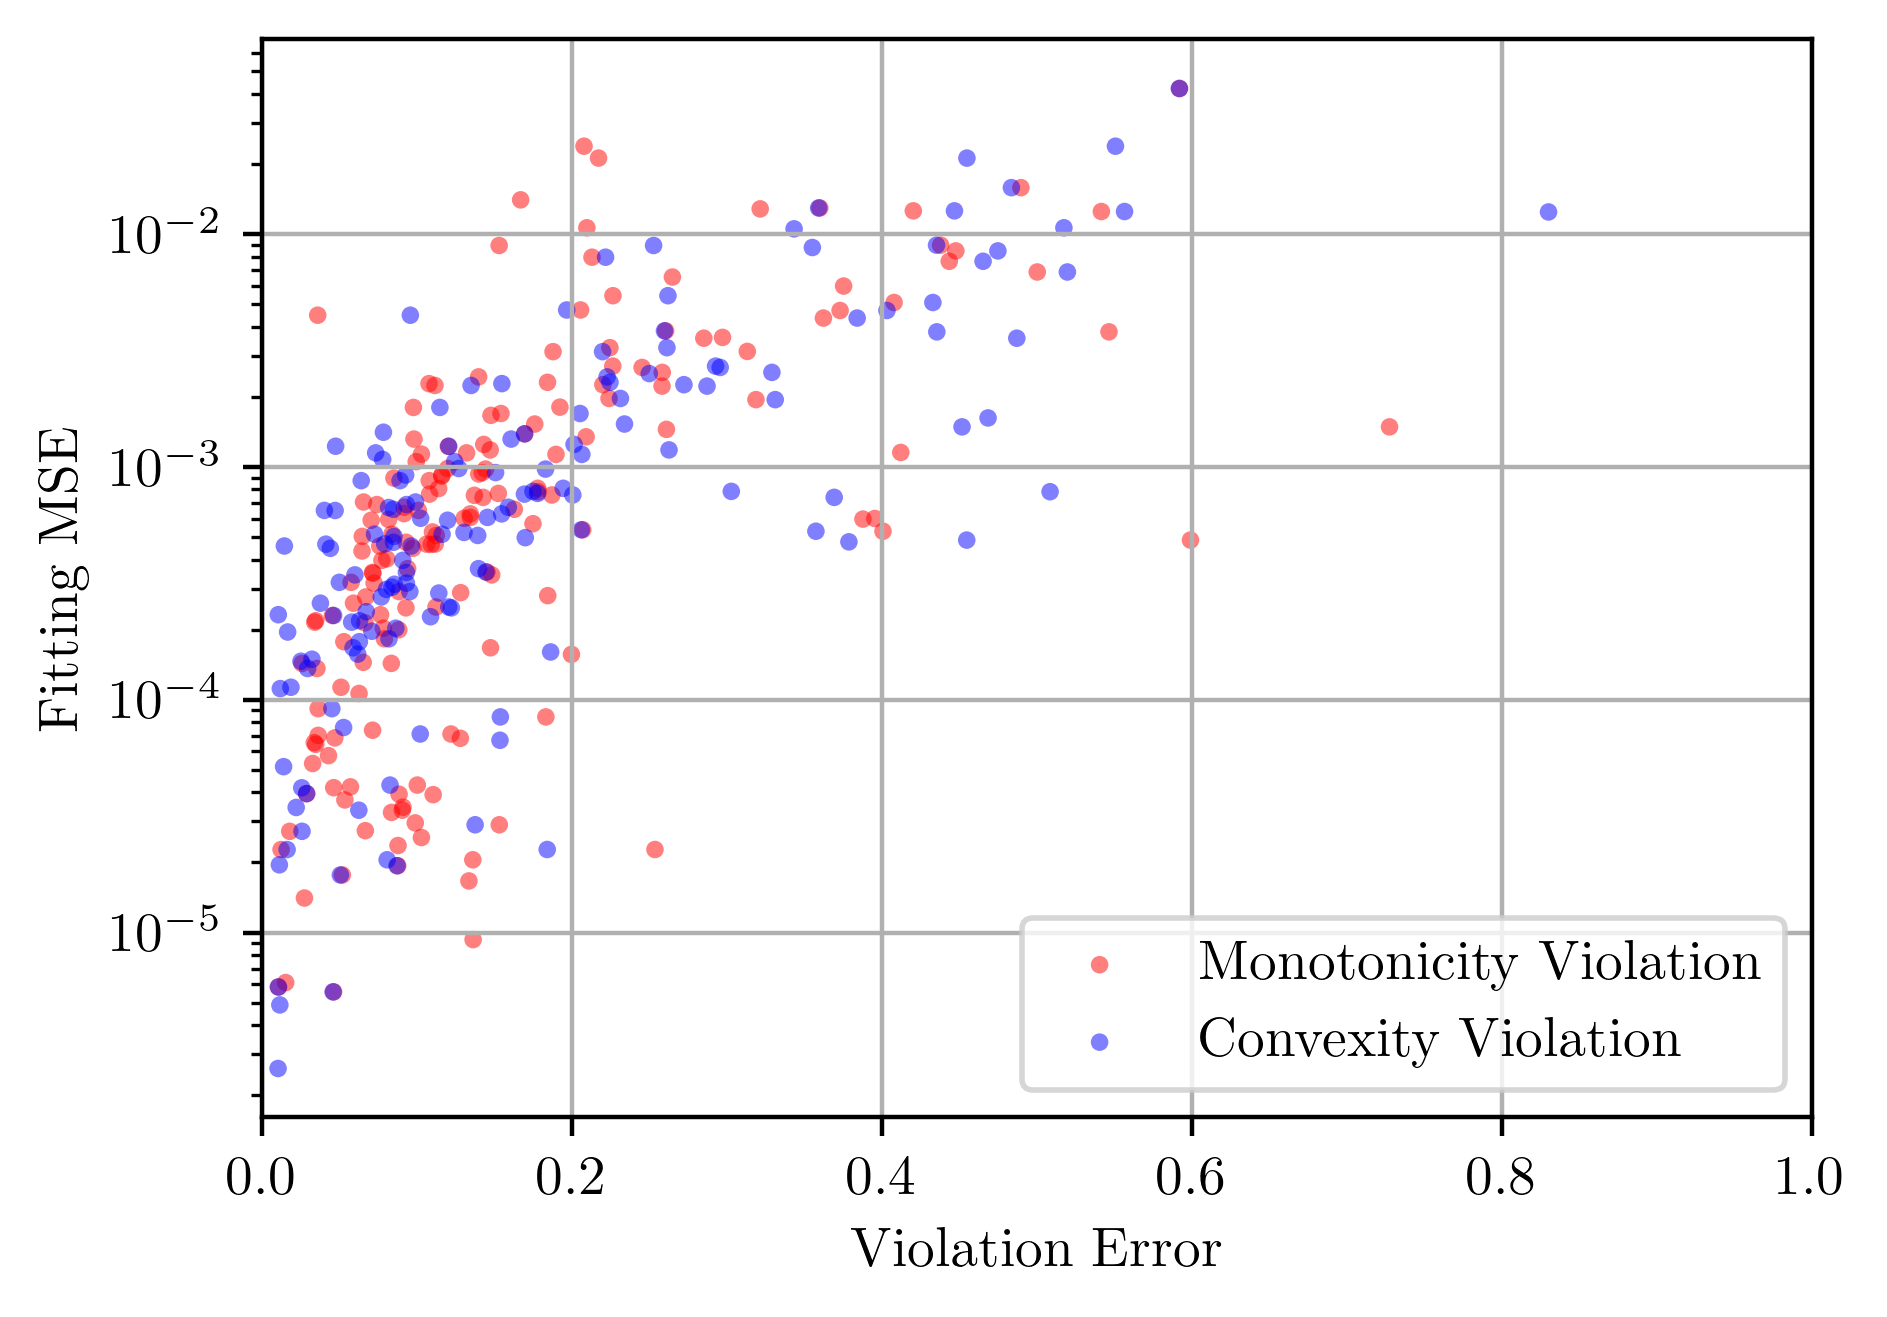

In [10]:
MSE_values = fit_MSE_matrix.flatten()
mono_y_values = mono_matrix_y.flatten()
conv_y_values = conv_matrix.flatten()

# Monotone case (y_values == 0)
valid_mask_mono = ~np.isnan(MSE_values) & ~np.isnan(mono_y_values) & (mono_y_values == 0)
# Monotonicity violated case (y_values > 0)
valid_mask_mono_violated = ~np.isnan(MSE_values) & ~np.isnan(mono_y_values) & (mono_y_values > 0)

# Convexity violated case (y_values > 0)
valid_mask_conv_violated = ~np.isnan(MSE_values) & ~np.isnan(conv_y_values) & (conv_y_values > 0)

# Plotting
plt.figure(figsize=(5, 3.5), dpi=400)
# Scatter points for monotonicity violation
plt.scatter(mono_y_values[valid_mask_mono_violated], MSE_values[valid_mask_mono_violated], alpha=0.5, s=10, c='r', label="Monotonicity Violation", edgecolors='none')
# Scatter points for convexity violation
plt.scatter(conv_y_values[valid_mask_conv_violated], MSE_values[valid_mask_conv_violated], alpha=0.5, s=10, c='b', label="Convexity Violation", edgecolors='none')

plt.xlabel("Violation Error")
plt.ylabel("Fitting MSE")
plt.xlim(0,1)
plt.yscale("log")
plt.grid()
plt.legend(loc='lower right')
plt.show()
